# Document Description

This notebook is concerned with the trends in the number of days the MJO occurs in each phase (sub and normal) each wet season. This notebook includes the calculations for the trends as well as the plotting of this information>

# Packages

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

import sys
from importlib import reload
sys.path.append('/home/563/ab2313/MJO/functions')

In [10]:
import sys
from importlib import reload
sys.path.append('')

# This is for loading in all the data sets that have been used in this study.
import load_dataset as load

# For splitting all of the data sets into the different phases.
import phase_calc_functions as phase_calc

# Collection of functions for plotting MJO phases.
import phase_plot_functions as phase_plot

# Collection of statistics
import mystats


# Data

In [11]:
rmm = load.load_rmm()
# rmm = phase_calc.load_rmm()

# Maths

In [12]:
rmm_ws = phase_calc.wet_season_year(rmm)

In [13]:
phase_calc = reload(phase_calc)
phase_count = phase_calc.count_in_rmm_phase(rmm_ws)

In [14]:
phase_count = phase_count.sel(year = slice(1976, 2019))

In [17]:
phase_count

<xarray.Dataset>
Dimensions:  (phase: 9, year: 44)
Coordinates:
  * phase    (phase) <U8 '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * year     (year) int64 1976 1977 1978 1979 1980 ... 2015 2016 2017 2018 2019
Data variables:
    number   (phase, year) int64 0 6 11 6 0 6 9 1 16 ... 23 33 43 29 18 56 15 23

In [15]:
# Countring the days in each Wheeler and Hendon Phase
phase_calc = reload(phase_calc)

# The number of days in each MJO phase (1-8) each wet season.
rmm_count = phase_calc.count_in_rmm_phase(rmm_ws)

# The number of days in each MJO subphase each wet season.
rmm_count_sub = phase_calc.resample_phase_to_subphase(rmm_count)

# Selecting just the years that are in the AWAP data set as RMM has a longer recored (till current date always).
subphase_count = rmm_count_sub.isel(year = slice(0,43))

In [16]:
subphase_count

<xarray.Dataset>
Dimensions:  (phase: 4, year: 43)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    number   (phase, year) int64 21 28 25 18 23 28 11 ... 54 23 33 43 29 18 56

In [18]:
phase_count

<xarray.Dataset>
Dimensions:  (phase: 9, year: 44)
Coordinates:
  * phase    (phase) <U8 '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * year     (year) int64 1976 1977 1978 1979 1980 ... 2015 2016 2017 2018 2019
Data variables:
    number   (phase, year) int64 0 6 11 6 0 6 9 1 16 ... 23 33 43 29 18 56 15 23

In [21]:
rmm_ws

<xarray.Dataset>
Dimensions:    (time: 5647)
Coordinates:
  * time       (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2021-12-31
Data variables:
    RMM1       (time) float64 0.3499 0.4019 0.5453 ... 0.2166 0.1951 0.062
    RMM2       (time) float64 -1.022 -1.218 -1.07 ... -0.202 -0.358 -0.5308
    phase      (time) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 7.0 3.0 4.0 3.0 3.0
    amplitude  (time) float64 1.08 1.283 1.201 1.086 ... 0.2961 0.4077 0.5344

In [65]:
rmm_ws = rmm_ws.where(np.logical_and(rmm_ws.phase < 10, rmm_ws.amplitude < 10), np.nan)

In [66]:
year_vals = np.unique(rmm_ws.time.dt.year.values)
year_vals

array([1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021])

In [67]:
y1 = year_vals[:int((len(year_vals) - 1)/2)]
y2 = year_vals[int((len(year_vals) - 1)/2):]
y1, y2

(array([1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
        1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
        1997]),
 array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
        2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
        2020, 2021]))

In [68]:
period1 = rmm_ws.where(rmm_ws.time.dt.year.isin(y1), drop = True).drop(['RMM1','RMM2'])
period2 = rmm_ws.where(rmm_ws.time.dt.year.isin(y2), drop = True).drop(['RMM1','RMM2'])
period1, period2

(<xarray.Dataset>
 Dimensions:    (time: 2789)
 Coordinates:
   * time       (time) datetime64[ns] 1975-01-01 1975-01-02 ... 1997-12-31
 Data variables:
     phase      (time) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 7.0 7.0 7.0 7.0 7.0
     amplitude  (time) float64 1.08 1.283 1.201 1.086 ... 3.568 3.445 3.179 3.024,
 <xarray.Dataset>
 Dimensions:    (time: 2858)
 Coordinates:
   * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2021-12-31
 Data variables:
     phase      (time) float64 6.0 6.0 6.0 7.0 7.0 8.0 ... 7.0 3.0 4.0 3.0 3.0
     amplitude  (time) float64 1.384 1.176 1.003 1.341 ... 0.2961 0.4077 0.5344)

In [104]:
empty = np.zeros((9,9))
empty

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [105]:
def check_next(p1, p2, a1, a2, empty):
 
    # If all are true, then this will return true. Else, if any are not finite then they are caught
    if all(np.isfinite([p1,p2,a1,a2])) == False:
        return
    else:
        if a1 < 1:
            p1 = 9
        if a2 < 1:
            p2 = 9


        empty[int(p1) - 1,int(p2) - 1] += 1
    

In [112]:
def check_phase_transition(phase, amp):

    empty = np.zeros((9,9))

    for i in range(len(phase) - 1):
        p1 = phase[i]
        p2 = phase[i + 1]

        a1 = amp[i]
        a2 = amp[i + 1]

        check_next(p1,p2,a1,a2, empty)
        
    return empty

In [175]:
phase1 = period1.phase.values
amp1 = period1.amplitude.values

phase_trans_1 = check_phase_transition(phase1, amp1)


phase2 = period2.phase.values
amp2 = period2.amplitude.values

phase_trans_2 = check_phase_transition(phase2, amp2)

In [176]:
phase_trans_1

array([[135.,  30.,   1.,   0.,   1.,   0.,   1.,   5.,  11.],
       [  3., 153.,  35.,   0.,   0.,   0.,   0.,   1.,  12.],
       [  0.,   2., 203.,  38.,   0.,   0.,   1.,   2.,  17.],
       [  0.,   0.,   4., 151.,  26.,   1.,   0.,   0.,  25.],
       [  0.,   0.,   0.,   2., 126.,  30.,   0.,   0.,  14.],
       [  0.,   1.,   0.,   0.,   3., 146.,  40.,   0.,  12.],
       [  0.,   0.,   0.,   0.,   0.,   9., 226.,  39.,  19.],
       [ 33.,   0.,   1.,   0.,   0.,   0.,   6., 198.,  27.],
       [ 13.,  18.,  19.,  17.,  16.,  16.,  19.,  20., 812.]])

In [177]:
phase_trans_diff_1 = []
for row in phase_trans_1:
    row[np.argmax(row)] = 0
    phase_trans_diff_1.append(row)
phase_trans_diff_1 = np.array(phase_trans_diff_1)

In [178]:
phase_trans_diff_1

array([[ 0., 30.,  1.,  0.,  1.,  0.,  1.,  5., 11.],
       [ 3.,  0., 35.,  0.,  0.,  0.,  0.,  1., 12.],
       [ 0.,  2.,  0., 38.,  0.,  0.,  1.,  2., 17.],
       [ 0.,  0.,  4.,  0., 26.,  1.,  0.,  0., 25.],
       [ 0.,  0.,  0.,  2.,  0., 30.,  0.,  0., 14.],
       [ 0.,  1.,  0.,  0.,  3.,  0., 40.,  0., 12.],
       [ 0.,  0.,  0.,  0.,  0.,  9.,  0., 39., 19.],
       [33.,  0.,  1.,  0.,  0.,  0.,  6.,  0., 27.],
       [13., 18., 19., 17., 16., 16., 19., 20.,  0.]])

In [179]:
phase_trans_diff_2 = []
for row in phase_trans_2:
    row[np.argmax(row)] = 0
    phase_trans_diff_2.append(row)
phase_trans_diff_2 = np.array(phase_trans_diff_2)

In [180]:
phase_trans_diff_2 

array([[ 0., 29.,  0.,  0.,  0.,  1.,  0.,  2., 11.],
       [ 2.,  0., 40.,  0.,  0.,  1.,  0.,  0., 10.],
       [ 0.,  8.,  0., 41.,  1.,  0.,  0.,  1., 14.],
       [ 0.,  0.,  3.,  0., 44.,  1.,  0.,  0., 15.],
       [ 0.,  0.,  1.,  4.,  0., 46.,  1.,  0., 22.],
       [ 0.,  0.,  1.,  1.,  5.,  0., 50.,  0., 26.],
       [ 0.,  0.,  1.,  1.,  2., 11.,  0., 41., 17.],
       [28.,  0.,  0.,  2.,  0.,  0.,  7.,  0., 17.],
       [13., 16., 19., 14., 22., 22., 15., 10.,  0.]])

In [181]:
percent_trans1 = np.round(phase_trans_1 * 100 / np.sum(phase_trans_1),1)
percent_trans2 = np.round(phase_trans_2 * 100 / np.sum(phase_trans_2),1)

In [182]:
percent_trans_diff_1 = np.round(phase_trans_diff_1 * 100 / np.sum(phase_trans_diff_1),1)
percent_trans_diff_2 = np.round(phase_trans_diff_2 * 100 / np.sum(phase_trans_diff_2),1)

In [183]:
percent_trans_diff_1

array([[0. , 5.1, 0.2, 0. , 0.2, 0. , 0.2, 0.8, 1.9],
       [0.5, 0. , 5.9, 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0.3, 0. , 6.4, 0. , 0. , 0.2, 0.3, 2.9],
       [0. , 0. , 0.7, 0. , 4.4, 0.2, 0. , 0. , 4.2],
       [0. , 0. , 0. , 0.3, 0. , 5.1, 0. , 0. , 2.4],
       [0. , 0.2, 0. , 0. , 0.5, 0. , 6.8, 0. , 2. ],
       [0. , 0. , 0. , 0. , 0. , 1.5, 0. , 6.6, 3.2],
       [5.6, 0. , 0.2, 0. , 0. , 0. , 1. , 0. , 4.6],
       [2.2, 3.1, 3.2, 2.9, 2.7, 2.7, 3.2, 3.4, 0. ]])

In [184]:
percent_trans_diff_2

array([[0. , 4.5, 0. , 0. , 0. , 0.2, 0. , 0.3, 1.7],
       [0.3, 0. , 6.3, 0. , 0. , 0.2, 0. , 0. , 1.6],
       [0. , 1.3, 0. , 6.4, 0.2, 0. , 0. , 0.2, 2.2],
       [0. , 0. , 0.5, 0. , 6.9, 0.2, 0. , 0. , 2.3],
       [0. , 0. , 0.2, 0.6, 0. , 7.2, 0.2, 0. , 3.4],
       [0. , 0. , 0.2, 0.2, 0.8, 0. , 7.8, 0. , 4.1],
       [0. , 0. , 0.2, 0.2, 0.3, 1.7, 0. , 6.4, 2.7],
       [4.4, 0. , 0. , 0.3, 0. , 0. , 1.1, 0. , 2.7],
       [2. , 2.5, 3. , 2.2, 3.4, 3.4, 2.3, 1.6, 0. ]])

In [186]:
max_trans_1 = np.max(percent_trans_diff_1, axis = 1)
max_trans_2 = np.max(percent_trans_diff_2, axis = 1)

In [203]:
np.arange(0,9,2)

array([0, 2, 4, 6, 8])

In [206]:
np.arange(0, len(max_trans_1))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

<BarContainer object of 9 artists>

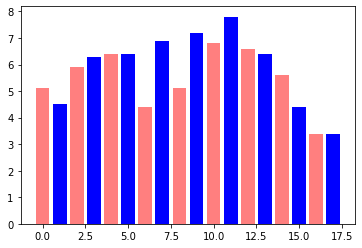

In [211]:
plt.bar(np.arange(0, 2 * len(max_trans_1), 2),max_trans_1, alpha = 0.5, zorder = 1, color = 'red')
plt.bar(np.arange(0, 2 * len(max_trans_1),2) + 1 ,max_trans_2, alpha = 1, zorder = 0, color = 'blue')

# Plotting

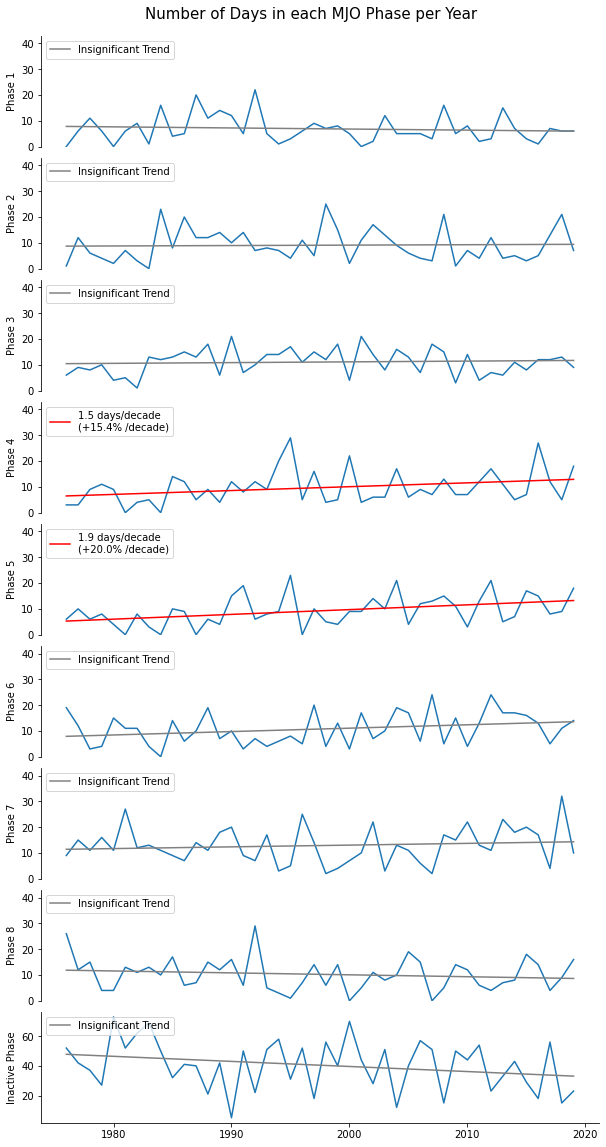

In [72]:
fig = plt.figure(figsize = (10,20))
gs = gridspec.GridSpec(9,1, hspace = 0.1)


sig_stor = []

for i,phase in enumerate(phase_count.phase.values):
    ax = fig.add_subplot(gs[i])
    
    sub = phase_count.sel(phase = phase).number
    x = sub.year.values
    y = sub.values

    raw = ax.plot(x,y, label = None)
    
    
    idx = np.isfinite(x) & np.isfinite(y)
    x = x[idx]
    y = y[idx]

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    
    sig = mystats.mann_kendall(y)  
    sig_stor.append(sig)

    if sig < 0.1:
        linestyle = '-'
        color = 'red'
        # The trend / mean * 100 (convert to percent) * 10 convert to per decade
        sub_vals = sub.values
        idx = np.isfinite(sub_vals)
        mean = np.mean(sub_vals[idx])
        
        percent_trend =  np.round(z[0] * 1000/ mean,1)
        label = str(np.round(z[0] * 10,1)) + ' days/decade\n(+{}% /decade)'.format(percent_trend)  
#         label = 'Significant Trend:' + str(np.round(z[0] * 10,2)) + ' days per decade'  
    else:
        linestyle = '-'
        color = 'grey'
        label = 'Insignificant Trend'
    
    trend = ax.plot(x, p(x), label = label, linestyle = linestyle, color = color) 

    

    # Defining titles
    if i == 8:
        ax.set_ylabel('Inactive Phase')
    else:
        ax.set_ylabel('Phase ' + phase)
        ax.set_ylim(0,43)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
    
        
    ax.legend(loc = 'upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

title = 'Number of Days in each MJO Phase per Year'
fig.suptitle(title, y =0.9, fontsize = 15 );

fig1 = fig
ax1 = ax

fig.savefig('../images/mjo_and_rainfall_trend_images/rmm_trend_phase_DecToMarch.png', dpi = 800,
           bbox_inches = 'tight')

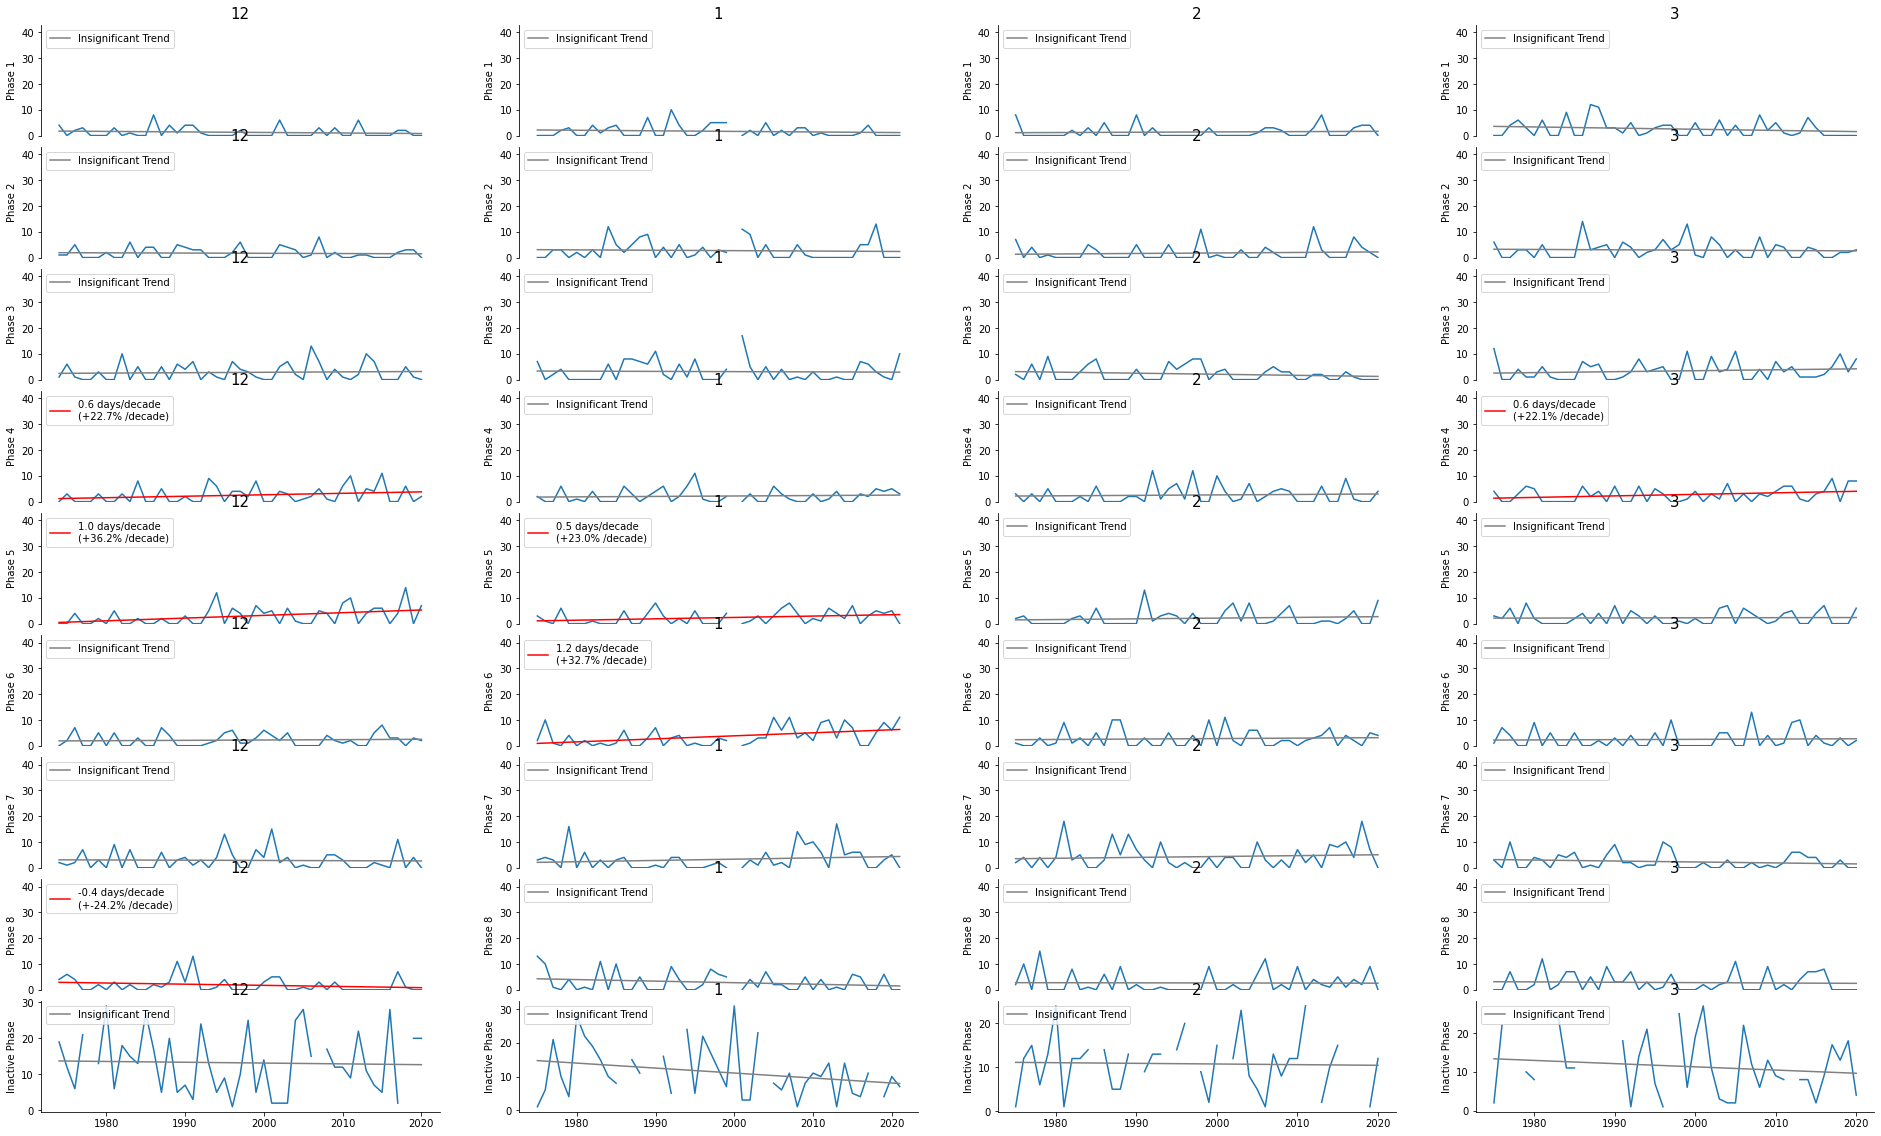

In [9]:
phase_calc = reload(phase_calc)


fig = plt.figure(figsize = (50,20))
gs = gridspec.GridSpec(9,6, hspace = 0.1)


sig_stor = []

for col, month in enumerate([12,1,2,3]):
    rmm_ws = rmm.where(rmm.time.dt.month == month, drop = True)
    phase_count = phase_calc.count_in_rmm_phase(rmm_ws)
    for i,phase in enumerate(phase_count.phase.values):
        ax = fig.add_subplot(gs[i, col])

        sub = phase_count.sel(phase = phase).number
        x = sub.year.values
        y = sub.values

        raw = ax.plot(x,y, label = None)


        idx = np.isfinite(x) & np.isfinite(y)
        x = x[idx]
        y = y[idx]

        z = np.polyfit(x,y,1)
        p = np.poly1d(z)

        sig = mystats.mann_kendall(y)  
        sig_stor.append(sig)

        if sig < 0.1:
            linestyle = '-'
            color = 'red'
            # The trend / mean * 100 (convert to percent) * 10 convert to per decade
            sub_vals = sub.values
            idx = np.isfinite(sub_vals)
            mean = np.mean(sub_vals[idx])

            percent_trend =  np.round(z[0] * 1000/ mean,1)
            label = str(np.round(z[0] * 10,1)) + ' days/decade\n(+{}% /decade)'.format(percent_trend)  
    #         label = 'Significant Trend:' + str(np.round(z[0] * 10,2)) + ' days per decade'  
        else:
            linestyle = '-'
            color = 'grey'
            label = 'Insignificant Trend'

        trend = ax.plot(x, p(x), label = label, linestyle = linestyle, color = color) 

        if ~i:
            ax.set_title(str(month), size = 15)
        

        # Defining titles
        if i == 8:
            ax.set_ylabel('Inactive Phase')
        else:
            ax.set_ylabel('Phase ' + phase)
            ax.set_ylim(0,43)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])


        ax.legend(loc = 'upper left')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


# Subphase

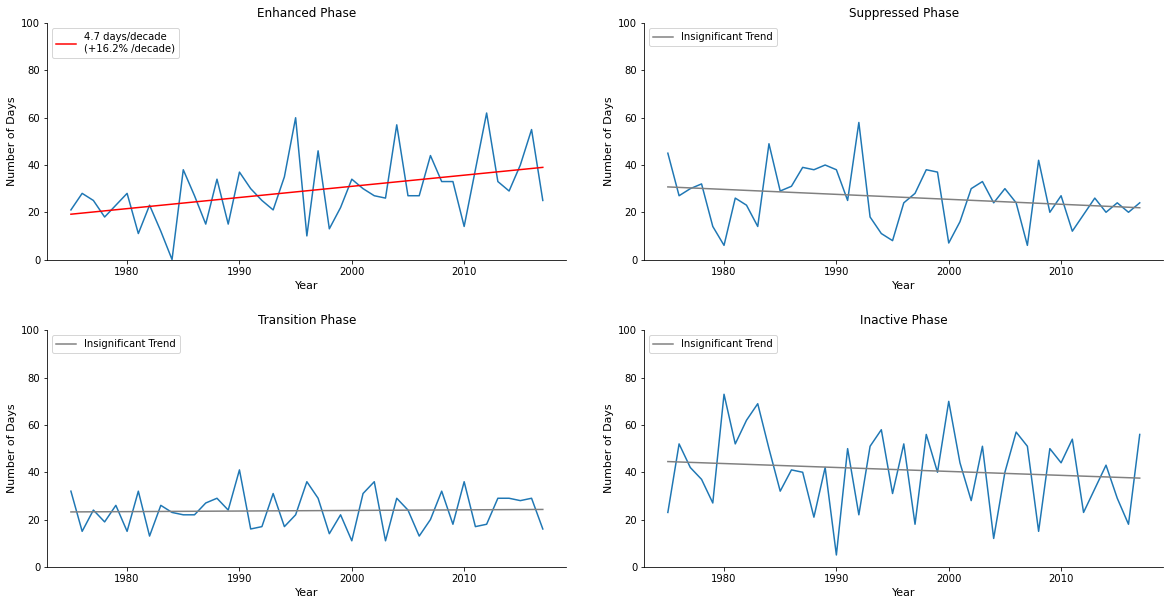

In [47]:
fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(2,2, hspace = 0.3, wspace = 0.15)

for i,phase in enumerate(subphase_count.phase.values):
    ax = fig.add_subplot(gs[i])
    
    sub = subphase_count.sel(phase = phase).number
    x = sub.year.values
    y = sub.values

    raw = ax.plot(x,y, label = None)    
    
    idx = np.isfinite(x) & np.isfinite(y)
    x = x[idx]
    y = y[idx]

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    
    sig = mystats.mann_kendall(y)  

    if sig < 0.1:
        linestyle = '-'
        # The trend / mean * 100 (convert to percent) * 10 convert to per decade
        percent_trend =  np.round(z[0] * 1000/ np.mean(sub.values),1)
        label = str(np.round(z[0] * 10,1)) + ' days/decade\n(+{}% /decade)'.format(percent_trend)  
        color = 'red'
    else:
        linestyle = '-'
        label = 'Insignificant Trend'
        color = 'grey'
    
    trend = ax.plot(x, p(x), label = label, linestyle = linestyle, color = color) 

    ax.set_ylim(10,80)

    # Defining titles
    ax.set_title('{} Phase'.format(phase.capitalize()))
 
    ax.set_ylim([0,100])
    ax.set_xlabel('Year', size = 11)
    ax.set_ylabel('Number of Days', size = 11)
    ax.legend(loc = 'upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.savefig('../images/mjo_and_rainfall_trend_images/rmm_trend_subphase_DecToMarch.png', dpi = 800,
           bbox_inches = 'tight')

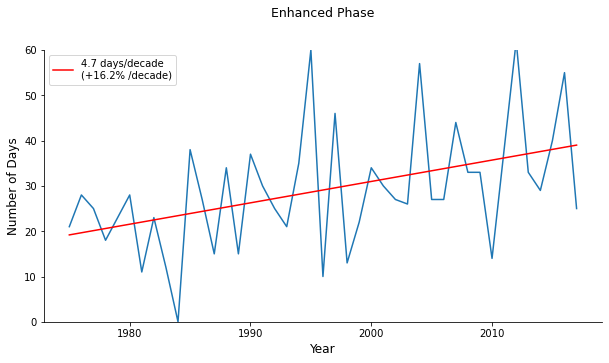

In [27]:
fig = plt.figure(figsize = (10,5))
gs = gridspec.GridSpec(1,1)

for i,phase in enumerate(['enhanced']):
    ax = fig.add_subplot(gs[i])
    
    sub = subphase_count.sel(phase = phase).number
    x = sub.year.values
    y = sub.values

    raw = ax.plot(x,y, label = None)    
    
    idx = np.isfinite(x) & np.isfinite(y)
    x = x[idx]
    y = y[idx]

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    
    sig = mystats.mann_kendall(y)  

    if sig < 0.1:
        linestyle = '-'
        # The trend / mean * 100 (convert to percent) * 10 convert to per decade
        percent_trend =  np.round(z[0] * 1000/ np.mean(sub.values),1)
        label = str(np.round(z[0] * 10,1)) + ' days/decade\n(+{}% /decade)'.format(percent_trend)  
        color = 'red'
    else:
        linestyle = '-'
        label = 'Insignificant Trend'
        color = 'grey'
    
    trend = ax.plot(x, p(x), label = label, linestyle = linestyle, color = color) 


    # Defining titles
    ax.set_title('{} Phase'.format(phase.capitalize()), size = 12.5, y = 1.1)
#     ax.annotate('c', xy = (0.1,0.95), xycoords = 'axes fraction', fontsize = 12)
 
    ax.set_ylim([0,60])
    ax.set_xlabel('Year', size = 12)
    ax.set_ylabel('Number of Days', size = 12)
    ax.legend(loc = 'upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.savefig('../images/mjo_and_rainfall_trend_images/rmm_trend_enhanced_DecToMarch.png', dpi = 400,
           bbox_inches = 'tight')

# Phase and Subphase

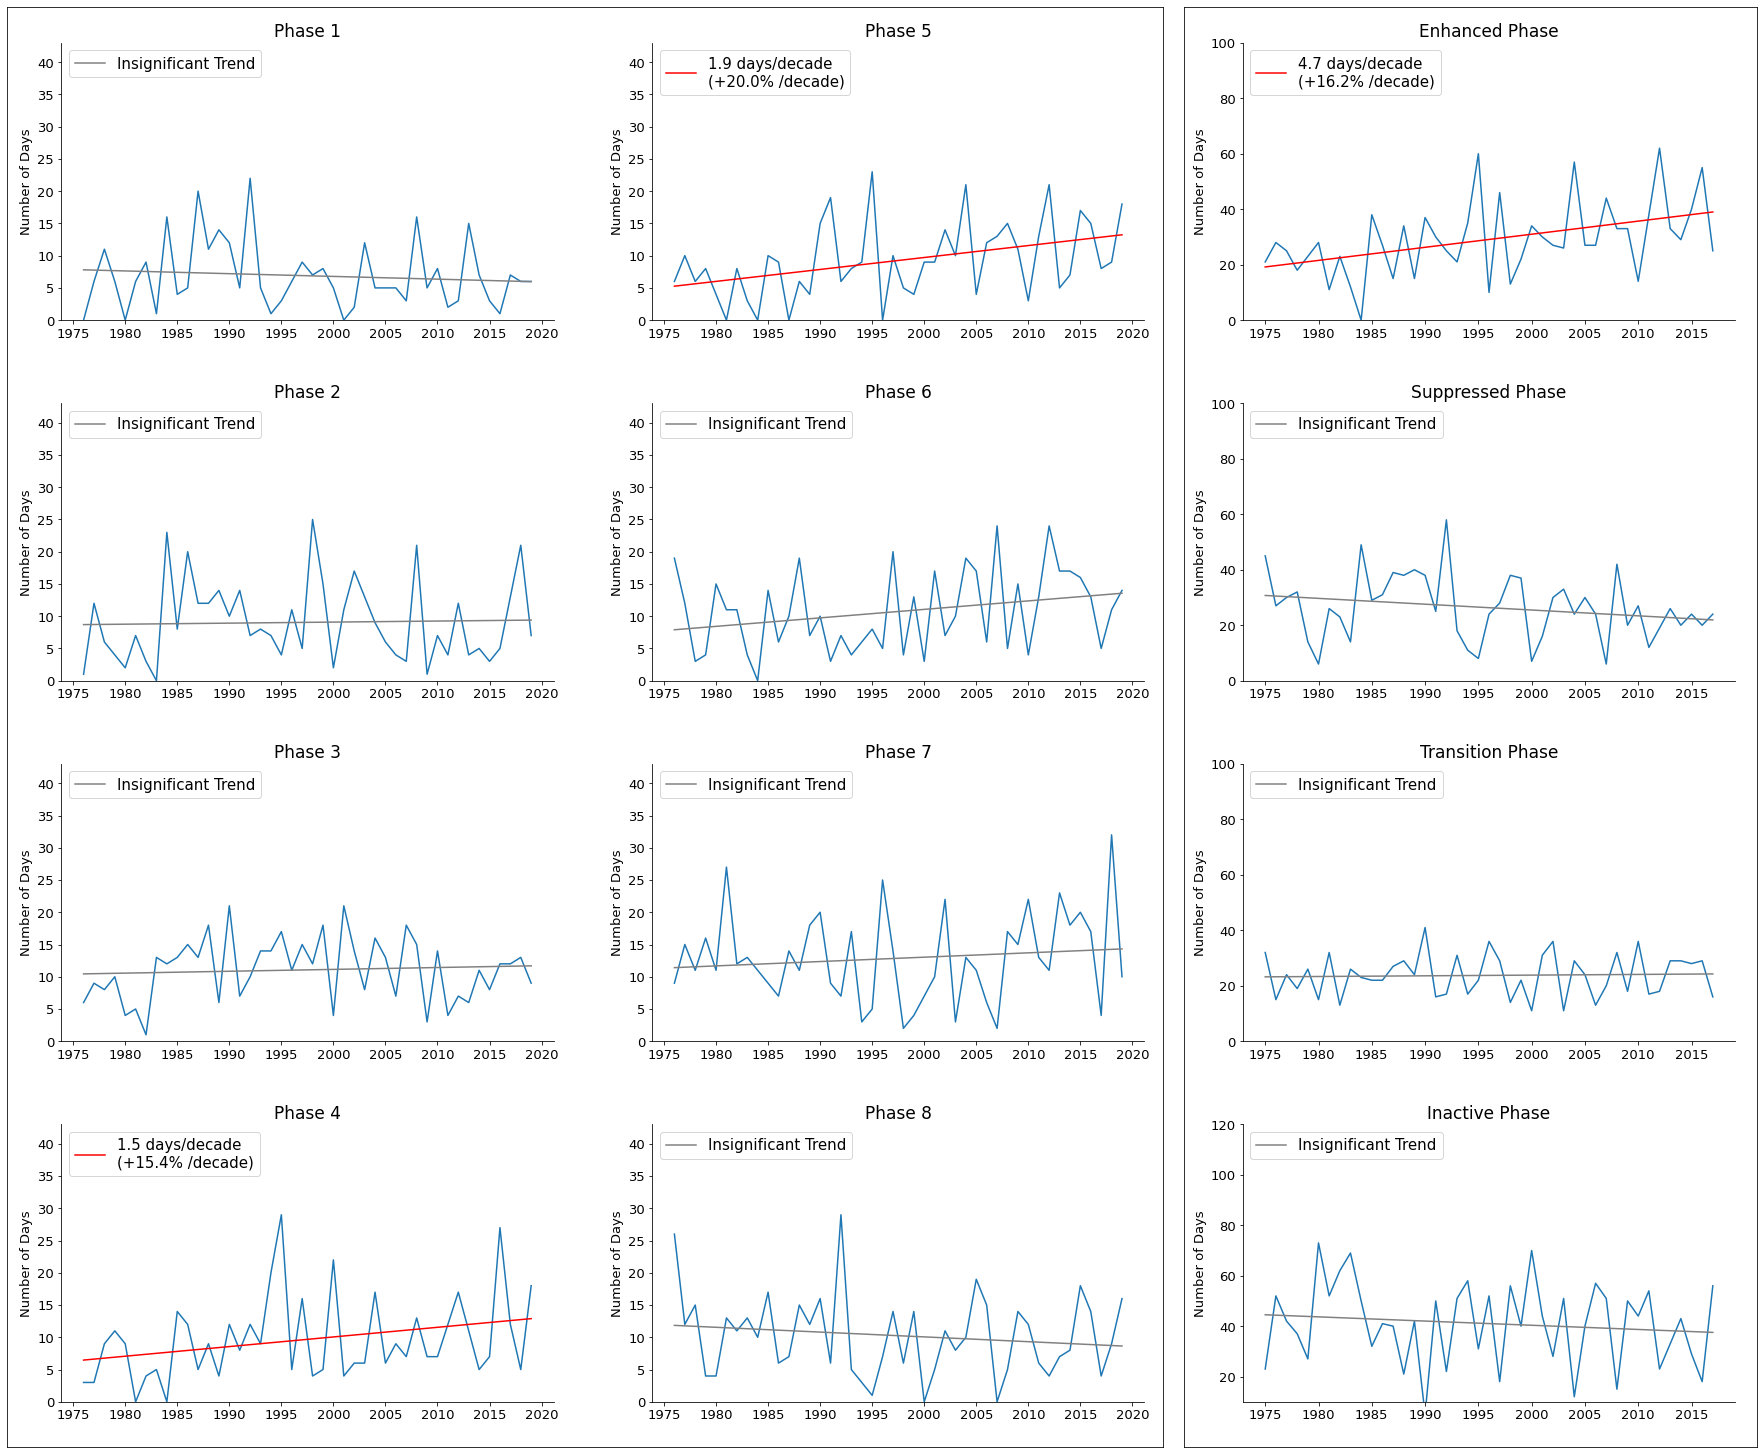

In [30]:
fig = plt.figure(figsize = (30,25))
gs = gridspec.GridSpec(4,3, hspace = 0.3)



phasegs = gridspec.GridSpec(1, 1)
phasegs.update(bottom = .1, left = .1 , right = .635 , top = .9)
phaseax = fig.add_subplot(phasegs[0])
phaseax.tick_params(axis='both',which='both',bottom=0,left=0,
                    labelbottom=0, labelleft=0)
# phaseax.set_facecolor(colors[2])
# phaseax.patch.set_alpha(0.3)

subPhasegs = gridspec.GridSpec(1, 1)
subPhasegs.update(bottom = .1, left = .645 , right = .91 , top = .9)
subPhaseax = fig.add_subplot(subPhasegs[0])
subPhaseax.tick_params(axis='both',which='both',bottom=0,left=0,
                    labelbottom=0, labelleft=0)
# subPhaseax.set_facecolor(colors[1])
# subPhaseax.patch.set_alpha(0.3)





# Subphases
for i,phase in enumerate(subphase_count.phase.values):
    ax = fig.add_subplot(gs[i,2])
    
    sub = subphase_count.sel(phase = phase).number
    x = sub.year.values
    y = sub.values

    raw = ax.plot(x,y, label = None)
    
    
    idx = np.isfinite(x) & np.isfinite(y)
    x = x[idx]
    y = y[idx]

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    
    sig = mystats.mann_kendall(y)  

    if sig < 0.1:
        linestyle = '-'
        # The trend / mean * 100 (convert to percent) * 10 convert to per decade
        percent_trend =  np.round(z[0] * 1000/ np.mean(sub.values),1)
        label = str(np.round(z[0] * 10,1)) + ' days/decade\n(+{}% /decade)'.format(percent_trend)  
        color = 'red'
    else:
        linestyle = '-'
        label = 'Insignificant Trend'
        color = 'grey'
    
    trend = ax.plot(x, p(x), label = label, linestyle = linestyle, color = color) 

    ax.set_ylim(10,120)

    # Defining titles
    if i == 3:
        ax.set_title('Inactive Phase', fontsize = 17)
#         ax.set_ylabel('Inactive', fontsize = 15)

    else:
        ax.set_title(phase.capitalize() + ' Phase', fontsize = 17)
#         ax.set_ylabel(phase.capitalize(), fontsize = 15)
 
        ax.set_ylim([0,100])
    
    ax.set_ylabel('Number of Days', size = 13.1)
    ax.legend(loc = 'upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

    ax.legend(loc = 'upper left', fontsize = 15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 13.1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

# title = 'Number of Days in each MJO Sub-Phase per Wet Season'
# fig.suptitle(title, y =0.9, fontsize = 15 );


################# Phases

sig_stor = []

row = 0
col = 0

for i,phase in enumerate(phase_count.phase.values):
    
    if phase == 'inactive':
        break
    
    ax = fig.add_subplot(gs[row,col])
    
    sub = phase_count.sel(phase = phase).number
    sub = sub.fillna(0)
    x = sub.year.values
    y = sub.values

    raw = ax.plot(x,y, label = None)
    
    
    idx = np.isfinite(x) & np.isfinite(y)
    x = x[idx]
    y = y[idx]

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    
    sig = mystats.mann_kendall(y)  
    sig_stor.append(sig)

    if sig < 0.1:
        linestyle = '-'
        color = 'red'
        # The trend / mean * 100 (convert to percent) * 10 convert to per decade

        sub_vals = sub.values
        
        idx = np.isfinite(sub_vals)
        mean = np.mean(sub_vals[idx])
        
        percent_trend =  np.round(z[0] * 1000/ mean,1)
        label = str(np.round(z[0] * 10,1)) + ' days/decade\n(+{}% /decade)'.format(percent_trend)  
#         label = 'Significant Trend:' + str(np.round(z[0] * 10,2)) + ' days per decade'  
    else:
        linestyle = '-'
        color = 'grey'
        label = 'Insignificant Trend'
    
    trend = ax.plot(x, p(x), label = label, linestyle = linestyle, color = color) 

    
    ax.set_title('Phase ' + phase, size = 17)
    ax.set_ylabel('Number of Days', size = 13.1)
#     ax.set_ylabel(phase, size = 15, rotation = 0, labelpad = 15)
    ax.set_ylim(0,43) 
    ax.legend(loc = 'upper left', fontsize = 15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 13.1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
#     ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g $\pi$'))
    
    row += 1
    
    if row == 4:
        row = 0
        col = 1
    
fig.savefig('../images/mjo_and_rainfall_trend_images/rmm_trend_phase_and_subphase_DecToMarch.png', dpi = 800,
           bbox_inches = 'tight')